**Exercise 9 - Object Detection**

---

In this exercise you will work with object detection. Currently there are plenty of different methods and algorithms to deal with object detection. In this task you will implement a method called *CenterNet*. This method uses a CNN to infer the objects center and it's height and width. Given the predicted center and it's size, a bounding box can be drawn around the detected object.


**CenterNet**

---

The *CenterNet* method was proposed by Zhou et al. in *"Objects as Points"* [\[1\]](https://arxiv.org/pdf/1904.07850.pdf). The central idea is to predict the objects centers and sizes, and then drawn the detection bounding box using this information. To do so, they use the *ResNet* [\[2\]](https://arxiv.org/pdf/1512.03385.pdf) architecture, add upsampling convolutions at the end of the architecture, and two parallel final convolutions, one to predict the heatmap, and other to predict the objects size.

[//]: # (mlrcv/notebook_images/centernet.png)

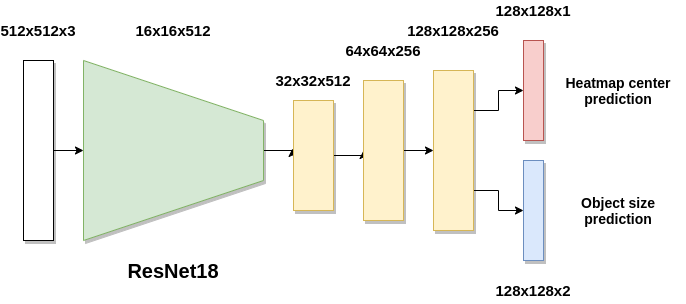

In [ ]:
from IPython.display import Image
Image('mlrcv/notebook_images/centernet.png')

**Heatmap**

---

To train the detection network, a pre-processing is done on the training data to generate the ground truth images. First, a gaussian heatmap is drawn for each object on the dataset inside it's bounding box. Then, this heatmap is placed on the correspondent location on target ground truth, building an image with the heatmaps of every object. Note that, the input image has shape *($Height$, $Width$, 3)* and the generated heatmap has shape *($\frac{Height}{4}$, $\frac{Width}{4}$, 1)*, the same shape as the network output. It's generated a smaller heatmap image in order to save processing during training. 

[//]: #(mlrcv/notebook_images/heatmap.png)

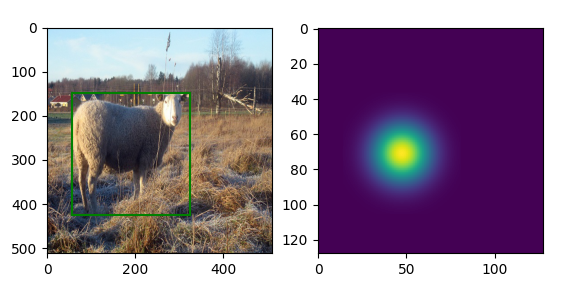

In [2]:
from IPython.display import Image
Image('mlrcv/notebook_images/heatmap.png')

The idea of using heatmaps instead of only the centers, is to give to the network a wider "search" region to find the center, by arriving at the non-negative heatmap points, it can then converge to it's center by following the region "heat". Given this heatmap, a focal-loss is used to train the network to infer this heatmap.


**Sizemap**

---

The second task is to infer the objects sizes. To do so, it's generated a second ground truth image for the object size regression with shape *($\frac{Height}{4}$, $\frac{Width}{4}$,2)*. This image has zeros every, except for the objects centers positions, where the values are the object size *(height,width)*.

[//]: #(mlrcv/notebook_images/sizemap.png)



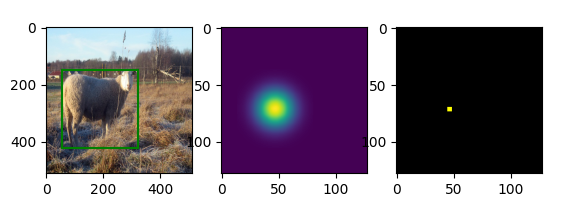

In [3]:
from IPython.display import Image
Image('mlrcv/notebook_images/sizemap.png')

Given this sizemap image, it's used a smooth L1 loss applied only over the non-zero values, i.e., the objects centers.

**Your Task**

---

This exercise is divided in four main task:
- Implement the function to generate the heatmaps for the dataset images
- Implement the function to generate the sizemaps for the dataset images
- Implement the focal loss function
- Implement the smooth L1 loss function
- Train the network using your implementations

Note that you should read the original CenterNet paper [\[1\]](https://arxiv.org/pdf/1904.07850.pdf) to understand how to implement it. Also, to train the network and finish the assignment it will be necessary to use pytorch with CUDA. Thereat, if you have GPUs at hand you can execute everything locally, otherwise you should use [Google Colab](https://colab.research.google.com/) where you can remotely execute your code on GPU for free.

We have implemented a *Trainer* with all the optimizers, and training iterations implemented. This trainer also has implemented an extensive logging, tracking the losses during training and plotting the intermediary results, so you could keep track of your tests and debugging without needing to wait the network finish training. All the loggings are recorded using [tensorboard](https://www.tensorflow.org/tensorboard).

**NOTE:** On the paper an *offset* value is also predicted. Since the network predicts a smaller image *($\frac{Height}{4}$, $\frac{Width}{4}$)* they learn an offset value, to correct possible shifts when resizing the outputs to the original image shape. However, in this exercise you don't need to deal with the offset values prediction.

In [ ]:
# do some directory setup
!mkdir center_logs
!mkdir checkpoint

**ONLY IF USING GOOGLE COLAB**

---

You should upload the directories *data/* and *mlrcv/* to Google Drive. Create a directory *ex9_data/ex9/* on your Google Drive main directory and upload both directories there. Then, run the cell above and follow the described steps to allow the Google Colab to access this data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir data
!mkdir mlrcv

!cp -r /content/drive/MyDrive/ex9_data/ex9/data/* ./data/
!cp -r /content/drive/MyDrive/ex9_data/ex9/mlrcv/* ./mlrcv/

For the next cells both, running on google colab or locally are necessary and you can run them on both cases.

**Importing the code**

---

In [1]:
#!pip3 install pytorch_lightning
import torch
import torchvision
from pytorch_lightning import Trainer
from mlrcv.model import CenterNet
from mlrcv.pre_process import *
from mlrcv.collation import *
from mlrcv.loss import *
from mlrcv.trainer import CenterNetTrainer
from mlrcv.utils import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

/home/lucas/.local/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


**9.1 Heatmap \[4.5\]**

---




Using the previous and the paper instructions you should implement the function *heatmap_object* in *mlrcv/pre_process.py* to build the objects heatmap image. This function receives as arguments the original RGB image, a heatmap image, which will be the output, and a label dictionary, which contains the bounding box for a single object. Your implemented function will be used inside pytorch collation, to generate the batches containing the input and ground truth images.

To be more modularized your function receives the bounding box of only one object, so you read the object bounding box, construct a heatmap given it's bounding box, and place it on the *heatmap* passed as argument on the same position as the object. The *heatmap* argument is necessary because, in the case of more than one object, your method will be called once for each object, so you just update the passed heatmap with the new calculated object heatmap.

**NOTE:** *Remember that both heatmap and sizemap are smaller than the original image ($\frac{Height}{4}$, $\frac{Width}{4}$) so keep that in mind if you find any problem with your solution.*

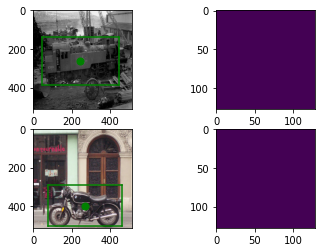

In [2]:
test_data = torchvision.datasets.VOCDetection('./data', year='2007', image_set='test')
test_loader = torch.utils.data.DataLoader(test_data,
                                        batch_size=2,
                                        collate_fn=VOCollation(test='heatmap'),
                                        shuffle=True,
                                        num_workers=0)

it = iter(test_loader)
img, lbl, heatmap = it.next()
plot_img_bb_test(img, lbl, heatmap)

As in the previous image, after running the cell above you should see the original image with the object bounding box and center drawn on the left side, and the respective heatmap drawn on the right.

**9.2 Sizemap \[4.5\]**

---



Using the previous and the paper instructions you should implement the function *sizemap_object* in *mlrcv/pre_process.py* to build the objects sizemap image. This function receives as arguments the original RGB image, a sizemap image, which will be the output, and a label dictionary, which contains the bounding box for a single object.

Again your function receives the bounding box of only one object, so you read the object bounding box, gets the object center and write the object height and width on the *sizemap* received as argument. For convention, given a pixel of shape *($i$,$j$,2)*, the height value should be written on *($i$,$j$,0)* and the width written on *($i$,$j$,1)*. As in the heatmap, the $sizemap$ argument is necessary because, in the case of more than one object, your method will be called once for each object, so you just update the passed sizemap with the object size.

**NOTE:** *Remember that both heatmap and sizemap are smaller than the original image ($\frac{Height}{4}$, $\frac{Width}{4}$) so keep that in mind if you find any problem with your solution.*

/home/lucas/PhD/Teaching/exercises-mlrob/Exercise9/mlrcv_ex9/mlrcv/collation.py:80: RuntimeWarning: invalid value encountered in true_divide
  sz[...,0] /= sz[...,0].max()
/home/lucas/PhD/Teaching/exercises-mlrob/Exercise9/mlrcv_ex9/mlrcv/collation.py:81: RuntimeWarning: invalid value encountered in true_divide
  sz[...,1] /= sz[...,1].max()
/home/lucas/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/lucas/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/lucas/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


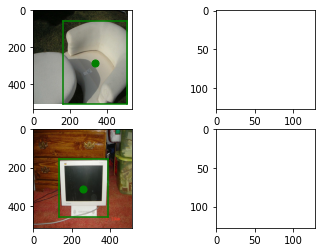

In [3]:
test_data = torchvision.datasets.VOCDetection('./data', year='2007', image_set='test')
test_loader = torch.utils.data.DataLoader(test_data,
                                        batch_size=2,
                                        collate_fn=VOCollation(test='sizemap'),
                                        shuffle=True,
                                        num_workers=0)

it = iter(test_loader)
img, lbl, sizemap = it.next()
plot_img_bb_test(img, lbl, sizemap)

As in the previous image, after running the cell above you should see the original image with the object bounding box and center drawn on the left side, and the respective sizemap drawn on the right (with only the objects centers coloured).

**9.3 Focal-loss \[4.5\]**

---



You should implement the focal-loss used on the paper. By reading the paper and checking it's description of the loss you can implement on python using pytorch. This loss is used to during training to learn to infer the objects center heatmaps. You should implement the function *focal_loss* in *mlrcv/loss.py* and validate your implementation by running the cell below.

In [ ]:
gt_loss = [0.0, 0.0, 0.0, 0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.17, 0.24, 0.33, 0.44, 0.59, 0.78, 1.03, 1.37, 1.87, 2.7]

step = []
loss = []


for i in range(1,20):
    a = torch.from_numpy(np.ones((1,)) * (1. - i/20.))
    b = torch.from_numpy(np.ones((1,)))
    c = focal_loss(a,b)

    step.append(1. - i/20.)
    loss.append(round(c.item(),2))


plt.plot(step, gt_loss, color='green', label='expected')
plt.plot(step, loss, ':', color='red', label='output')
plt.legend(loc='upper right')
plt.show()


The cell above has the expected loss outputs on *gt_loss*, to validate your implementation you can run this cell and check if your loss (red dotted line) corresponds to the ground truth (green line).

**9.4 Smooth L1-Loss \[4.5\]**

---

To infer the objects size it's used a smooth L1 loss. You should implement the *smooth_l1_loss* inside the *mlrcv/loss.py* file. Using the cell below you can test your implementation by comparing again both plots, the expected and your loss output.

In [ ]:
gt_loss = [0.0, 0.0, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1, 0.12, 0.15, 0.18, 0.21, 0.24, 0.28, 0.32, 0.36, 0.4, 0.45]

step = []
loss = []

for i in range(1,20):
    mask = np.ones((1,)) > 0
    a = torch.from_numpy(np.ones((1,)) * (1. - i/20.))
    b = torch.from_numpy(np.ones((1,)))
    c = smooth_l1_loss(a,b,mask)

    step.append(1. - i/20.)
    loss.append(round(c.item(),2))

plt.plot(step, gt_loss, color='green', label='expected')
plt.plot(step, loss, ':', color='red', label='output')
plt.legend(loc='upper right')
plt.show()

The cell above has the expected loss outputs on gt_loss, to validate your implementation you can run this cell and check if your loss (red dotted line) corresponds to the ground truth (green line).

**9.5 Training the network \[2\]**

---

Now that you have implemented the necessary modules you run the following code to train the network. The training steps are logged using tensorboard, which can be started inside notebooks, so you can keep track of the training/validation losses and image bounding box predictions.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)
])

train_data = torchvision.datasets.VOCDetection('./data', year='2007', image_set='train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,
                                        batch_size=16,
                                        shuffle=True,
                                        collate_fn=VOCollation(),
                                        num_workers=10)

test_data = torchvision.datasets.VOCDetection('./data', year='2007', image_set='test')
test_loader = torch.utils.data.DataLoader(test_data,
                                        batch_size=16,
                                        collate_fn=VOCollation(),
                                        num_workers=10)

Before start the training, start tensorboard. The logs will be saved in the *center_logs/*, so you can start tensorboard inside the notebook, or through terminal by running *```tensorboard --logdir=center_logs```* which then can be visualized on the browser acessing *localhost:6006*.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir center_logs

Now you can start the training and follow the training through tensorboard.

In [ ]:
# lr same as paper
# more epochs because we have a smaller dataset, so we need more iterations
lr = 5e-4
epochs = 500

model = CenterNet().cuda()
centernet = CenterNetTrainer(model, centerloss, (1.0, 0.5), train_loader, test_loader, lr, epochs)

trainer = Trainer(gpus=[0], max_epochs=epochs, check_val_every_n_epoch=50)
trainer.fit(centernet)

Note that the training may take around 2h~3h to bring relevant results, that's why it's important to check if every previous task have been correctly implemented and to keep track of the logs, so you can stop the training once you notice already that something is not right. After around 150 epochs you should see on tensorboard the mIoU metric increasing from close to 0% to around 60%.

The final goal of this task is not to achieve any specific accuracy, but you should save the training output on the python notebook and submit also the tensorboard log, so we can check training progress and see if everything worked fine.

**Assignment Submission**

---

You should zip and submit the ```ex9_object_detection.ipynb``` file together with all the ```.py``` files inside the ```mlrcv/``` directory and the `center_logs` directory.

**DO NOT** submit the `data` directory!

You can automatically generate the submission file using the provided ```zip_submission.sh``` script by running:

```
bash zip_submission.sh
```

This will zip the necessary files for your submission and generate the ```ex9_mlrcv_submission.zip``` file to be submit via ecampus.